In [52]:
# importing library
import warnings
warnings.filterwarnings('ignore')

import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cross_validation import train_test_split # for spliting dataset
from sklearn.feature_extraction.text import CountVectorizer # bow-->1gram and 2 gram
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from gensim.models import Word2Vec  # w2v
from gensim.models import KeyedVectors # to understanding w2v using google pre trained model
from sklearn.metrics import accuracy_score # to check the accuracy of model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score # k-fold cv
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
# remove '#' sign to download data-set
#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3575.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/kaggle-datasets/18/2157/Reviews.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1539455264&Signature=sUXQz0kX2395nqKOQppw23fSVbEPjFPhNtI1TC5FN1fOhx8RBGKLP1d1UZgiftoI1XI3TLxlFu6JwY%2BL7LwhxM46VQp89iJ%2BJZ8PaaY%2F61q8y%2BVchuDT8v4UnmbJ5%2Bkvf77HaNiJrAcqSY1K0C66npHhhaAgMzmvHJtTOnpZ70LFbZ6g1X%2Bh%2Ba2Tmkuiae%2F3CVIjnkE7sO2X4l3o5x4H45gu3EWzyrlqWJDwx0EJmDbnsOCsCzIEie7in70HwkDOwxGq9WdCGscFlFVDfd8W%2BV00yUfT82%2F2%2F4H4WGrnvI0uxFECct3b0n1F%2BbACM0sO0gvmmXAZNgbeOIpsUAclRw%3D%3D" -O "Reviews.csv.zip" -c

In [3]:
# remove '#' sign to unzip the dataset
"""import zipfile
data=zipfile.ZipFile("Reviews.csv.zip")
data.extractall()"""

'import zipfile\ndata=zipfile.ZipFile("Reviews.csv.zip")\ndata.extractall()'

>   # Loading the dataset

In [4]:
#loading the amazon dataset
dataset=pd.read_csv("Reviews.csv")

In [5]:
print(dataset.shape)
dataset.head()


(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


> # preprocessing the data

In [6]:
# sorting the value
dataset.sort_values(by='Id',inplace=True )
#finding the dublicate values using 'df.dublicated'
dataset[dataset.duplicated(subset={'ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'})].shape
#alternate way to drop dublicate values
dataset_no_dup=dataset.drop_duplicates(subset={'ProfileName','Score','Time','Summary'},keep='first')
print(f"before {dataset.shape}")
print(f"after removing duplicate values-->shape = {dataset_no_dup.shape}")
# %age of no. of review reamin in data set
(dataset_no_dup.size/dataset.size)*100

# removing reviews where "HelpfulnessNumerator>HelpfulnessDenominator"
dataset_no_dup=dataset_no_dup[dataset_no_dup['HelpfulnessNumerator']<=dataset_no_dup['HelpfulnessDenominator']]


before (568454, 10)
after removing duplicate values-->shape = (393141, 10)


In [7]:
# taking reviews whose score is not equal to 3
filtered_dataset=dataset_no_dup[dataset_no_dup['Score']!=3]
filtered_dataset.shape
#creating a function to filter the reviews (if score>3 --> positive , if score<3 --> negative)
def partition(x):
    if x>3:
        return 'positive'
    else:
        return 'negative'

score=filtered_dataset['Score']
pos_neg=score.map(partition)
filtered_dataset['Score']=pos_neg
print(filtered_dataset.shape)
filtered_dataset.head()


(363393, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
# changing the format of timestamp to ('%Y-%m-%d %H:%M:%S'

import time
import datetime
time=[]
for timestamp in filtered_dataset['Time']:
    t=datetime.datetime.fromtimestamp(timestamp).strftime(('%Y-%m-%d %H:%M:%S'))
    time.append(t)
filtered_dataset['time']=time   

In [9]:
# sort by time
filtered_dataset.sort_values(by='time',inplace=True)

In [10]:

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

sno = nltk.stem.SnowballStemmer('english')#snowball stemmer

stop=set(stopwords.words('english')) #set of stopwords

#clean html tags
def cleanhtml(sent):
    pattern=re.compile(r'<.*?>')
    cleansent=re.sub(pattern," ",sent)
    return cleansent

#cleean punctuation
def cleanpunc(word):
    clean_punc=re.sub(r'[?|!|\'|"|#]',' ',word)
    clean_punc=re.sub(r'[.|,|)|(|\|/]',' ',clean_punc)
    return clean_punc

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adityaadarsh99/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
import string

x=0 # number of reviews you want to clean/pre-processed
positive_words=[]
negative_words=[]
str1=''
final_sent=[] # storing the list of final pre-processed sentences
i=0

for sent in filtered_dataset["Text"]:
    sent=cleanhtml(sent) #removing html tags
    filtered_sentence=[]
    for w in sent.split():
        for clean_words in cleanpunc(w).split():
            if((len(clean_words)>2) & (clean_words.isalpha())):
                if (clean_words.lower() not in stop):
                    s=(sno.stem(clean_words.lower()))
                    filtered_sentence.append(s)
                    if (filtered_dataset['Score'].values[i]=='positive'):
                        positive_words.append(s)
                    if (filtered_dataset['Score'].values[i]=='negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1=" ".join(filtered_sentence) #str of all the cleaned words
    final_sent.append(str1) # appending cleaned words to sentence
    i=i+1
          

In [12]:
print(len(final_sent))
print("\nBefore cleaning :\n",filtered_dataset["Text"][10])
print(f"\nAfter cleaning :\n {final_sent[10]}")



363393

Before cleaning :
 I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!

After cleaning :
 get crazi realli imposs today find french vhs version film could pleas tell someth tks


In [13]:
filtered_dataset['cleaned_text']=final_sent
print(filtered_dataset.shape)
filtered_dataset.head()

(363393, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,time,cleaned_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08 03:00:00,witti littl book make son laugh loud recit car...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1999-10-25 03:00:00,rememb see show air televis year ago child sis...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,1999-12-02 03:00:00,beetlejuic well written movi everyth excel act...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06 03:00:00,twist rumplestiskin captur film star michael k...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,2000-01-03 03:00:00,beetlejuic excel funni movi keaton hilari wack...


## 1. Bag of word

In [14]:
# one gram-BOW from "sklean.feature_extraction.text.CountVectorizer"
count_vect=CountVectorizer()
bow_cleaned_text=count_vect.fit_transform(filtered_dataset['cleaned_text'])


In [14]:
# two gram_BOW 
count_vect_gram=CountVectorizer(ngram_range=(1,2))
bow_cleaned_text_2gram=count_vect_gram.fit_transform(filtered_dataset['cleaned_text'])

In [15]:
print("bow_cleaned_text",bow_cleaned_text.shape)
print("bow_cleaned_text_2gram",bow_cleaned_text_2gram.shape)

bow_cleaned_text (363393, 70047)
bow_cleaned_text_2gram (363393, 2881737)


## 2. TF-IDF

In [15]:
# tf-idf "from sklearn.feature_extraction.text.TfidfVectorizer"
tf_idf=TfidfVectorizer()
tf_idf_cleaned_text=tf_idf.fit_transform(filtered_dataset['cleaned_text'])

In [17]:
tf_idf_cleaned_text.shape

(363393, 70047)

In [18]:
# tf-idf 2-gram --> increasing no. of gram can increase the no. of dimension drastically
tf_idf_2gram = TfidfVectorizer(ngram_range=(1,2))
tf_idf_cleaned_text_2gram = tf_idf_2gram.fit_transform(filtered_dataset['cleaned_text'].values)
print("the type of count vectorizer ",type(tf_idf_cleaned_text_2gram))
print("the shape of out text TFIDF vectorizer ",tf_idf_cleaned_text_2gram.get_shape())
print("the number of unique words including both unigrams and bigrams ", tf_idf_cleaned_text_2gram.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (363393, 2881737)
the number of unique words including both unigrams and bigrams  2881737


## 3. avg word2vec

In [20]:
"""# understanding w2v using goolgle trained model of 300 dimension
# w2v lib from "gensim.models import KeyedVectors"
from gensim.models import KeyedVectors
google_w2v=KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz",encoding='utf8',binary=True)
"""

'# understanding w2v using goolgle trained model of 300 dimension\n# w2v lib from "gensim.models import KeyedVectors"\nfrom gensim.models import KeyedVectors\ngoogle_w2v=KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz",encoding=\'utf8\',binary=True)\n'

In [21]:
"""google_w2v.distance('woman','queen')"""

"google_w2v.distance('woman','queen')"

In [16]:
# converting our text-->vector using w2v with 50-dim
# more the dimension of each word = better the semantic of word
# using lib from "gensim.models.Word2Vec"
# to run w2v we need list of list of the words as w2v covert each world into number of dim

list_of_sent=[]
for sent in filtered_dataset['cleaned_text'].values:
    list_of_sent.append((str(sent)).split())
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50)
# vocablary of w2v model of amazon dataset
vocab=w2v_model.wv.vocab
len(vocab)

21817

In [17]:
# understanding w2v on amzon fine food reviews dataset
w2v_model.similar_by_word('women')

/home/adityaadarsh99/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/home/adityaadarsh99/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('men', 0.801190972328186),
 ('hypothyroid', 0.7887751460075378),
 ('reproduct', 0.7742730379104614),
 ('surgeon', 0.7650048136711121),
 ('profess', 0.7603486180305481),
 ('alzheim', 0.7558683156967163),
 ('cardiac', 0.7451004981994629),
 ('fighter', 0.7446705102920532),
 ('lactat', 0.7424254417419434),
 ('practition', 0.7419098615646362)]

In [ ]:
# w2v representaion of word "women" in 50-dim
w2v_model.wv['women']

In [17]:
'''
-->procedure to make avg w2v of each reviews
    1. find the w2v of each word
    2. sum-up w2v of each word in a sentence
    3. divide the total w2v of sentence by total no. of words in the sentence
'''

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent[:20000]: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

print(len(sent_vectors))
print(len(sent_vectors[0]))

20000
50


In [18]:
sent_vectors[0] #avg w2v of first sentences

array([-0.43964782,  0.34591733,  0.50716974,  0.63616721,  0.21764897,
        0.15437841, -0.24710238, -0.68204595, -0.07492292,  0.29527832,
        0.10464046,  0.18491844, -0.11662304, -0.4002957 , -0.24036625,
        0.27034666, -0.3083803 , -0.34479962,  0.14284511, -0.50950451,
        0.04510599, -0.60782979,  0.01971852,  0.36105206, -0.18600377,
        0.25459591, -0.4211965 , -0.01466703, -0.64982405,  0.19603894,
       -0.17994684,  0.19611642, -0.41492236,  0.7808123 ,  0.1749674 ,
       -0.1720063 , -0.0179648 ,  0.31845266, -0.51565883, -0.93752195,
       -0.52541144, -0.0988581 ,  0.13649957, -0.39445148,  0.54237232,
        1.00254755,  0.33456012, -0.99758567, -0.00967862,  0.60130049])

## avg  TF-IDF W2V 

In [19]:
# tfidf words/col names
tfidf_feat = tf_idf.get_feature_names()

In [20]:
# TF-IDF weighted Word2Vec

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent[:20000]: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = tf_idf_cleaned_text[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [21]:
len(tfidf_sent_vectors)

20000

# Naive bayes on Amazon Fine Food Reviews

 
### The difference between  different naive bayes.

* Multi-variate Bernoulli Naive Bayes The binomial model is useful if your feature vectors are binary (i.e., 0s and 1s). One application would be text classification with a bag of words model where the 0s 1s are "word occurs in the document" and "word does not occur in the document"

* Multinomial Naive Bayes The multinomial naive Bayes model is typically used for discrete counts. E.g., if we have a text classification problem, we can take the idea of bernoulli trials one step further and instead of "word occurs in the document" we have "count how often word occurs in the document", you can think of it as "number of times outcome number x_i is observed over the n trials"

* Gaussian Naive Bayes Here, we assume that the features follow a normal distribution. Instead of discrete counts, we have continuous features (e.g., the popular Iris dataset where the features are sepal width, petal width, sepal length, petal length)

## *  naive based on Time based splitting dataset

In [137]:
                  
def timegausNB(xtrain,xtest,ytrain,ytest):
    
    #xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.33, random_state=42)

    gnb=GaussianNB() # gaussianNB doesn`t support smoothing
    acc=cross_val_score(gnb,xtrain,ytrain,cv=10, scoring='accuracy', n_jobs=1)

    # Generalization accuracy
    gnb=GaussianNB()
    gnb.fit(xtrain,ytrain)
    ypred=gnb.predict(xtest)
    print(f"\n Generalization accuracy = {accuracy_score(ytest,ypred)}\n")
    print(classification_report(ytest,ypred)) 
    
    df_cm = pd.DataFrame(confusion_matrix(ytest,ypred), range(2),range(2))
    sn.heatmap(cm,annot=True,annot_kws={"size": 16}, fmt='g')    

In [139]:
def timemultiNB(xtrain,xtest,ytrain,ytest):

    accuracy=[]
    final_report=[]
    #xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.33, random_state=42)

    for alpha in np.arange(10e-4,1,0.10):

        mnb=MultinomialNB(alpha=alpha)
        acc=cross_val_score(mnb,xtrain,ytrain,cv=10, scoring='accuracy', n_jobs=1)
        accuracy.append([max(acc),alpha])
        
    for alpha in np.arange(1,1000,100):

        mnb=MultinomialNB(alpha=alpha)
        acc=cross_val_score(mnb,xtrain,ytrain,cv=10, scoring='accuracy', n_jobs=1)
        accuracy.append([max(acc),alpha])
    
    print("accuracy result")
    score=pd.DataFrame(accuracy,columns=['accuracy','alpha'])
    print(score)
    print(f"\n maximum accuracy is {max(accuracy)[0]} at alpha {max(accuracy)[1]} on CV")
    # Generalization accuracy
    mnb=MultinomialNB(alpha=max(accuracy)[1])
    mnb.fit(xtrain,ytrain)
    ypred=mnb.predict(xtest)
    print(f"\n Generalization accuracy = {accuracy_score(ytest,ypred)}")
    print(classification_report(ytest,ypred)) 
    
    df_cm = pd.DataFrame(confusion_matrix(ytest,ypred), range(2),range(2))
    sn.heatmap(cm,annot=True,annot_kws={"size": 16}, fmt='g')    

## a. on BOW

accuracy result
    accuracy    alpha
0   0.912143    0.001
1   0.920000    0.101
2   0.917857    0.201
3   0.914286    0.301
4   0.907143    0.401
5   0.904286    0.501
6   0.900714    0.601
7   0.898571    0.701
8   0.895000    0.801
9   0.893571    0.901
10  0.893571    1.000
11  0.890714  101.000
12  0.890714  201.000
13  0.890714  301.000
14  0.890714  401.000
15  0.890714  501.000
16  0.890714  601.000
17  0.890714  701.000
18  0.890714  801.000
19  0.890714  901.000

 maximum accuracy is 0.92 at alpha 0.101 on CV

 Generalization accuracy = 0.8772528356320819
             precision    recall  f1-score   support

   negative       0.67      0.46      0.54     55520
   positive       0.90      0.96      0.93    293873

avg / total       0.87      0.88      0.87    349393



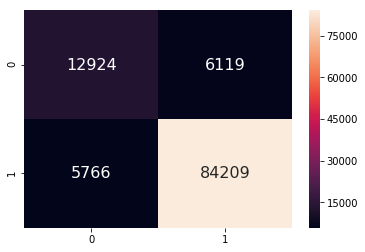

In [140]:
x=20000 #size of 'X'

xtrain=bow_cleaned_text[:round(x*0.70)]
xtest=bow_cleaned_text[round(x*0.70):]
ytrain=filtered_dataset["Score"][:round(x*0.70)]
ytest=filtered_dataset["Score"][round(x*0.70):]
timemultiNB(xtrain,xtest,ytrain,ytest)

#### feature importance of naive bayes


In [141]:
# feature importance of naive bayes
# using log probabilty as original probabilty values are too small


def feature_imprtance_NB(vectorizer,clf,n=25):
    a=mnb.fit(xtrain,ytrain)
    a.feature_log_prob_[0]
    vectorizor=count_vect
    a.feature_log_prob_[0]
    top_neg=sorted(zip(a.feature_log_prob_[0],vectorizor.get_feature_names()))[:-n:-1]
    top_pos=sorted(zip(a.feature_log_prob_[0],vectorizor.get_feature_names()))[:n:1]
    print(pd.DataFrame(top_neg,columns=['log-prob','negative-word']) )
    print("\n\n",pd.DataFrame(top_pos,columns=['log-prob','positive-word']) )
    
feature_imprtance_NB(count_vect,mnb,n=25)

    log-prob negative-word
0  -4.313199          tast
1  -4.371085          like
2  -4.514675       product
3  -4.765291           one
4  -4.895152           tri
5  -5.008722         order
6  -5.016268         would
7  -5.052252          good
8  -5.078772        flavor
9  -5.183505           get
10 -5.251411           use
11 -5.355672         coffe
12 -5.373555           tea
13 -5.380799           buy
14 -5.425399           box
15 -5.433030          make
16 -5.444586           eat
17 -5.521051          food
18 -5.521051           bag
19 -5.525242          even
20 -5.542184        realli
21 -5.563774          time
22 -5.585840          much
23 -5.664730        amazon


      log-prob                                 positive-word
0  -13.290572                                            aa
1  -13.290572                                           aaa
2  -13.290572                                          aaaa
3  -13.290572                                         aaaaa
4  -13.290572         

## b. on tf-idf

accuracy result
    accuracy    alpha
0   0.907143    0.001
1   0.892143    0.101
2   0.890714    0.201
3   0.890714    0.301
4   0.890714    0.401
5   0.890714    0.501
6   0.890714    0.601
7   0.890714    0.701
8   0.890714    0.801
9   0.890714    0.901
10  0.890714    1.000
11  0.890714  101.000
12  0.890714  201.000
13  0.890714  301.000
14  0.890714  401.000
15  0.890714  501.000
16  0.890714  601.000
17  0.890714  701.000
18  0.890714  801.000
19  0.890714  901.000

 maximum accuracy is 0.9071428571428571 at alpha 0.001 on CV

 Generalization accuracy = 0.8558471406124336
             precision    recall  f1-score   support

   negative       0.71      0.16      0.26     55520
   positive       0.86      0.99      0.92    293873

avg / total       0.84      0.86      0.82    349393



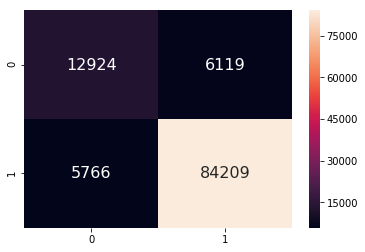

In [142]:
x=20000

xtrain=tf_idf_cleaned_text[:round(x*0.70)]
xtest=tf_idf_cleaned_text[round(x*0.70):]
ytrain=filtered_dataset["Score"][:round(x*0.70)]
ytest=filtered_dataset["Score"][round(x*0.70):]

timemultiNB(xtrain,xtest,ytrain,ytest)

## c. on avg w2v


 Generalization accuracy = 0.8682

             precision    recall  f1-score   support

   negative       0.41      0.52      0.46       538
   positive       0.94      0.91      0.92      4462

avg / total       0.88      0.87      0.87      5000



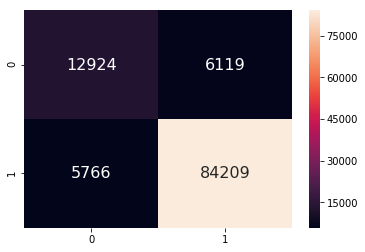

In [143]:
xtrain=sent_vectors[:15000]
xtest=sent_vectors[15000:]
ytrain=filtered_dataset["Score"][:15000]
ytest=filtered_dataset["Score"][15000:20000]

#timemultiNB(xtrain,xtest,ytrain,ytest)
timegausNB(xtrain,xtest,ytrain,ytest)



## d. on tfidf-avg w2v


 Generalization accuracy = 0.871

             precision    recall  f1-score   support

   negative       0.40      0.42      0.41       538
   positive       0.93      0.93      0.93      4462

avg / total       0.87      0.87      0.87      5000



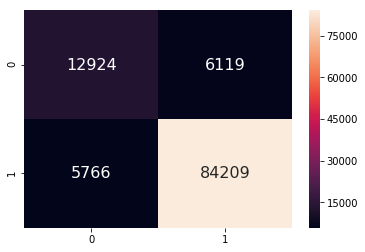

In [144]:
xtrain=tfidf_sent_vectors[:15000]
xtest=tfidf_sent_vectors[15000:]
ytrain=filtered_dataset["Score"][:15000]
ytest=filtered_dataset["Score"][15000:20000]

#timemultiNB(xtrain,xtest,ytrain,ytest)
timegausNB(xtrain,xtest,ytrain,ytest)
